In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

### Loading Data

In [2]:
ds = tfds.load("mnist", split="test+train", shuffle_files=True, as_supervised=True)

In [3]:
batch_size = 256
img_size = (28, 28)

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
def preprocess(img, _):
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

In [5]:
def prepare(ds: tf.data.Dataset):
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE).cache()

    return ds

In [6]:
train_ds = prepare(ds)

## DC GAN

In [28]:
from keras import layers

In [29]:
latent_size = 100

In [30]:
def build_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(latent_size,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, 5, strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, 5, strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, 5, strides=(2, 2), padding='same', use_bias=False, activation="tanh"),
        layers.BatchNormalization(),
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy")
    
    return model

#### Generate noise image

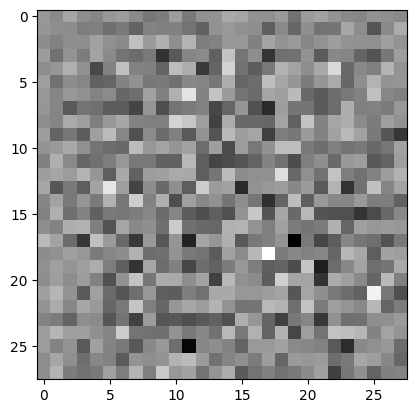

In [31]:
generator = build_generator_model()

noise = tf.random.normal([1, latent_size])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

In [32]:
def build_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, 2, padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 5, 2, padding='same',),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy")

    return model

In [33]:
discriminator = build_discriminator_model()

fake_output = discriminator(generated_image)

fake_output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00471333]], dtype=float32)>

### Losses & Optimizers

In [34]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)

    return real_loss + fake_loss

In [36]:
def generator_loss(fake):
    fake_loss = cross_entropy(tf.ones_like(fake), fake)
    return fake_loss

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Build Subclassed Model

In [38]:
class DCGAN(tf.keras.models.Model):
    def __init__(self, generator: tf.keras.models.Model, discriminator: tf.keras.models.Model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_opt: tf.keras.optimizers.Optimizer, d_opt: tf.keras.optimizers.Optimizer, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    
    def train_step(self, images):
        noise = tf.random.normal([batch_size, latent_size])

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            dis_loss = self.d_loss(real_output, fake_output)
            gen_loss = self.g_loss(fake_output)
        
        g_grads = g_tape.gradient(gen_loss, self.generator.trainable_variables)
        d_grads = d_tape.gradient(dis_loss, self.discriminator.trainable_variables)

        self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        self.d_opt.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        return {"g_loss": gen_loss, "d_loss": dis_loss}

In [39]:
generator = build_generator_model()
discriminator = build_discriminator_model()

In [40]:
dcgan = DCGAN(generator, discriminator)

In [41]:
dcgan.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [42]:
class SaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save("models/generator.h5")
        self.model.discriminator.save("models/discriminator.h5")

In [43]:
callbacks = [SaveModel()]

In [44]:
history = dcgan.fit(train_ds, epochs=500, callbacks=callbacks)

Epoch 1/500
274/274 [==============================] - 8s 27ms/step - g_loss: 3.0670 - d_loss: 0.2314
Epoch 2/500
274/274 [==============================] - 7s 26ms/step - g_loss: 5.5203 - d_loss: 0.0093
Epoch 3/500
274/274 [==============================] - 7s 26ms/step - g_loss: 6.0787 - d_loss: 0.0068
Epoch 4/500
274/274 [==============================] - 7s 26ms/step - g_loss: 6.3003 - d_loss: 0.0040
Epoch 5/500
274/274 [==============================] - 7s 26ms/step - g_loss: 6.8971 - d_loss: 0.0039
Epoch 6/500
274/274 [==============================] - 7s 26ms/step - g_loss: 7.8094 - d_loss: 0.0052
Epoch 7/500
274/274 [==============================] - 7s 26ms/step - g_loss: 8.5888 - d_loss: 0.0107
Epoch 8/500
274/274 [==============================] - 7s 26ms/step - g_loss: 9.1718 - d_loss: 0.0207
Epoch 9/500
274/274 [==============================] - 7s 26ms/step - g_loss: 7.8406 - d_loss: 0.0107
Epoch 10/500
274/274 [==============================] - 7s 26ms/step - g_loss: 7.8

### Performence Graph

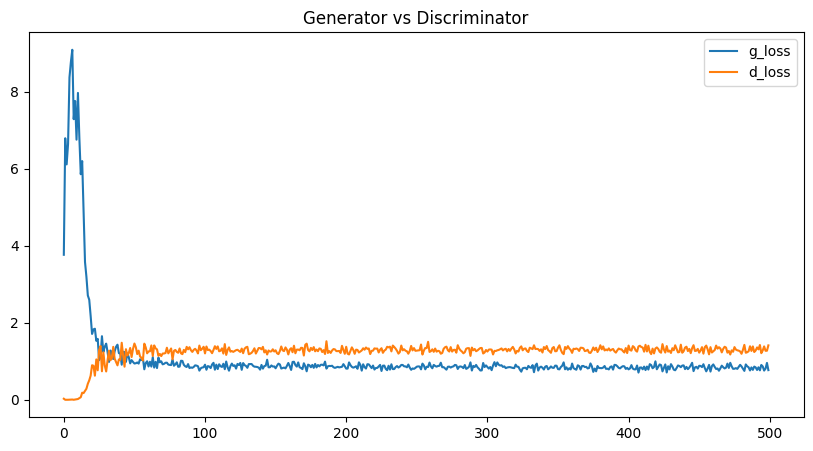

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["g_loss"])
plt.plot(history.history["d_loss"])
plt.title("Generator vs Discriminator")
plt.legend(['g_loss', 'd_loss'])
plt.show()

### Generate Images

In [46]:
def generate_images(model, test_input):
    generated_images = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
    
    plt.show()

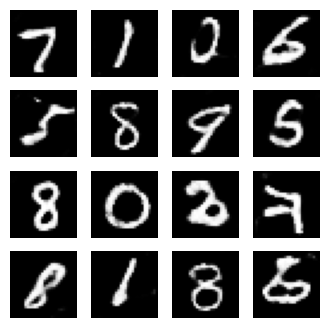

In [52]:
generate_images(dcgan.generator, tf.random.normal([16, latent_size]))